# Get data (X, y) for ANN model
- X (matrix of observations): cols = PM10, WS, WD, RH, Temp
- y (vector): daily change in SR

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Mojave test facility information
location = {'latitude': 34.987655,
            'longitude': -118.324051,
            'altitude': 1034.796,
            'timezone_dls': 'America/Los_Angeles',
            'timezone': 'Etc/GMT+8'}

## y (daily change in SR):
- read and filter
- remove rain and cleaning days

In [3]:
# read data from saved csv files (originally parquet files)
df_data = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\df_data.csv', 
                      index_col='date_time')
df_flag = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\df_flag.csv', 
                      index_col='date_time')

In [4]:
# After reading data from csv, datetime index type is changed to index
# So must convert index back to datetime index
new_ind = pd.Series(df_data.index)

for i in range(len(df_data)):
    new_ind[i] = pd.to_datetime(new_ind[i]).tz_convert(location['timezone'])
    
#set new index
df_data.set_index(new_ind, inplace=True)
df_flag.set_index(new_ind, inplace=True)

In [5]:
# Replace flagged data with NaN
for col in ['Soiling_ISC_1', 'Soiling_ISC_2', 'Rainfall']:
    df_data.loc[ df_flag[col].isin([1,2,3,4]), col ] = np.nan

In [6]:
# remove soiling current values < 0.5
df_data.loc[df_data['Soiling_ISC_1'] < 0.5] = np.nan
df_data.loc[df_data['Soiling_ISC_2'] < 0.5] = np.nan

In [7]:
## Create new df with daily data

# Soiling_ISC_1
soil1_ser = pd.Series(df_data['Soiling_ISC_1'], index=df_data.index)
df_daily = pd.DataFrame(soil1_ser.resample('D').sum())
# if < 200 min available for the day, replace that day of data with NaN
under_threshold = soil1_ser.resample('D').count() < 200
df_daily.loc[under_threshold] = np.nan

# Soiling_ISC_2
soil2_ser = pd.Series(df_data['Soiling_ISC_2'], index=df_data.index)
df_daily['Soiling_ISC_2'] = soil2_ser.resample('D').sum()
# if < 200 min available for the day, replace that day of data with NaN
under_threshold = soil2_ser.resample('D').count() < 200
df_daily.loc[under_threshold,'Soiling_ISC_2'] = np.nan

# Rainfall
rain_ser = pd.Series(df_data['Rainfall'], index=df_data.index)
df_daily['Rainfall'] = rain_ser.resample('D').sum()
under_threshold = rain_ser.resample('D').count() < 200
df_daily.loc[under_threshold,'Rainfall'] = np.nan

In [8]:
# remove dates where either ISC_1 or ISC_2 is NaN
df_daily.loc[df_daily['Soiling_ISC_1'].isna(), 'Soiling_ISC_2'] = np.nan
df_daily.loc[df_daily['Soiling_ISC_2'].isna(), 'Soiling_ISC_1'] = np.nan

In [46]:
# get soiling ratio
soiling_ratio = df_daily['Soiling_ISC_2'] / df_daily['Soiling_ISC_1']

# remove dates with rain
soiling_ratio.loc[df_daily['Rainfall'] != 0] = np.nan

In [47]:
## Remove dates with cleaning

# read cleaning log data
df_cleaning = pd.read_excel(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\Mojave Test Facility - Weekly Maintenance Form (Feb 2018).xlsx', 
                            usecols=[2,69], index_col=0)
df_cleaning.set_index(pd.to_datetime(df_cleaning.index).date, inplace=True)

# only keep dates with cleaning event
df_cleaning = df_cleaning.loc[df_cleaning['Is the "Clean Reference" Module Cleaned?'] == 'Yes']

# if cleaning event occurred
for ind in df_cleaning.index:
    # remove date from sratio
    soiling_ratio.loc[soiling_ratio.index.date == ind] = np.nan

<AxesSubplot:xlabel='date_time'>

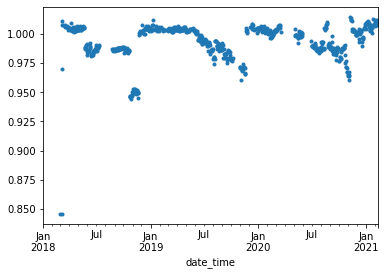

In [48]:
# investigate sratio values
soiling_ratio.plot(style='.')

<AxesSubplot:>

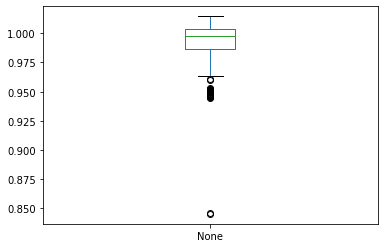

In [49]:
# investigate sratio values
soiling_ratio.plot(kind='box')

In [50]:
q1, q3 = soiling_ratio.quantile([.25,.75])
iqr = q3 - q1
outliers = q1 - (1.5*iqr)

In [51]:
soiling_ratio.loc[(soiling_ratio < outliers)]

date_time
2018-03-01 00:00:00-08:00    0.845912
2018-03-05 00:00:00-08:00    0.845297
2018-10-22 00:00:00-08:00    0.945650
2018-10-23 00:00:00-08:00    0.946082
2018-10-24 00:00:00-08:00    0.946743
2018-10-25 00:00:00-08:00    0.946648
2018-10-26 00:00:00-08:00    0.944385
2018-10-27 00:00:00-08:00    0.947039
2018-10-28 00:00:00-08:00    0.946751
2018-10-29 00:00:00-08:00    0.946826
2018-10-30 00:00:00-08:00    0.947595
2018-10-31 00:00:00-08:00    0.949866
2018-11-01 00:00:00-08:00    0.949892
2018-11-02 00:00:00-08:00    0.950966
2018-11-03 00:00:00-08:00    0.950319
2018-11-04 00:00:00-08:00    0.952778
2018-11-05 00:00:00-08:00    0.949598
2018-11-06 00:00:00-08:00    0.952373
2018-11-07 00:00:00-08:00    0.950267
2018-11-08 00:00:00-08:00    0.949364
2018-11-09 00:00:00-08:00    0.949171
2018-11-10 00:00:00-08:00    0.952388
2018-11-11 00:00:00-08:00    0.949611
2018-11-12 00:00:00-08:00    0.950993
2018-11-13 00:00:00-08:00    0.949698
2018-11-14 00:00:00-08:00    0.948231
20

In [52]:
# check if all dates exist in index: yes
pd.date_range(start = soiling_ratio.index.min(), end = soiling_ratio.index.max()).difference(soiling_ratio.index)

DatetimeIndex([], dtype='datetime64[ns, Etc/GMT+8]', freq=None)

In [54]:
# remove first 3 data points due to extremely low values
soiling_ratio.loc[soiling_ratio.dropna()[:3].index] = np.nan

# remove points between 10/22/2018 - 11/21/2018 due to sudden drop & stuck values
start = pd.to_datetime('10/22/2018')
end = pd.to_datetime('11/21/2018')
soiling_ratio[start:end] = np.nan

<AxesSubplot:xlabel='date_time'>

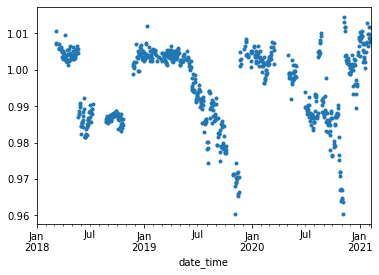

In [55]:
soiling_ratio.plot(style='.')

In [56]:
# get change in soiling ratio
model_data = pd.DataFrame(
    data = np.append(np.nan, (soiling_ratio[1:].values - soiling_ratio[:-1].values)),
    index = soiling_ratio.index,
    columns = ['y_sratio_change']
)

In [57]:
model_data.dropna()

,y_sratio_change
date_time,
2018-03-08 00:00:00-08:00,-0.003419
2018-03-09 00:00:00-08:00,-0.000144
2018-03-18 00:00:00-08:00,0.001519
2018-03-19 00:00:00-08:00,-0.001188
2018-03-25 00:00:00-08:00,0.000612
...,...
2021-02-05 00:00:00-08:00,0.001230
2021-02-06 00:00:00-08:00,-0.001017
2021-02-07 00:00:00-08:00,0.000708


<AxesSubplot:xlabel='date_time'>

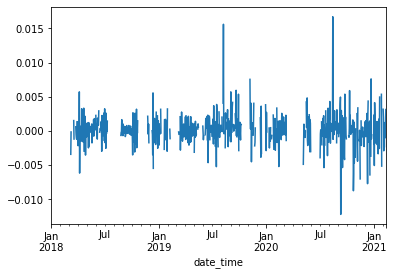

In [58]:
model_data['y_sratio_change'].plot()

## X_pm10
- present-day pm10 data; average hour measurement in a 24hr period
- data location: https://aqs.epa.gov/aqsweb/airdata/download_files.html
    - under Daily Data, scroll to Particulates table and download PM10 Mass (81102)
    - select rows: where 
        - Address = ' 923 POOLE STREET, MOJAVE, CA 93501' (closest monitoring site to MTF)
        - Sample Duration = '24-HR BLK AVG'
    - select column: 'Arithmetic Mean' (average value of the day)

In [59]:
## read data
pm10_2018 = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\pm10_daily_2018.csv', usecols=[9,11,16,23], index_col=1)
pm10_2019 = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\pm10_daily_2019.csv', usecols=[9,11,16,23], index_col=1)
pm10_2020 = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\Soiling Study\pm10_daily_2020.csv', usecols=[9,11,16,23], index_col=1)


## fix pm10_2018 index to match the format from other years
new_ind = []
for ind in pm10_2018.index:
    # separate date components
    month, day, year = ind.split('/')
    # add 0 paddings
    month = month.zfill(2)
    day = day.zfill(2)   
    # reformat mm/dd/yyyy to yyyy-mm-dd
    new_ind.append(year + '-' + month + '-' + day)
pm10_2018.index = new_ind


## get PM data from location closest to MTF and with given sample duration
pm10_2018 = pm10_2018.loc[(pm10_2018['Address'] == ' 923 POOLE STREET, MOJAVE, CA 93501') & (pm10_2018['Sample Duration'] == '24-HR BLK AVG')]
pm10_2019 = pm10_2019.loc[(pm10_2019['Address'] == ' 923 POOLE STREET, MOJAVE, CA 93501') & (pm10_2019['Sample Duration'] == '24-HR BLK AVG')]
pm10_2020 = pm10_2020.loc[(pm10_2020['Address'] == ' 923 POOLE STREET, MOJAVE, CA 93501') & (pm10_2020['Sample Duration'] == '24-HR BLK AVG')]


## combine years of PM data into one df
X_pm10 = pd.concat([pm10_2018, pm10_2019, pm10_2020]).drop(columns=['Address', 'Sample Duration'])
X_pm10.columns = ['X_pm10']


## make index tz aware
new_ind = pd.Series(X_pm10.index)
for i in range(len(X_pm10)):
    new_ind[i] = pd.to_datetime(new_ind[i]).tz_localize(location['timezone'])
    
# set new index
X_pm10.set_index(new_ind, inplace=True)

In [64]:
# add to model_data
model_data = pd.merge(X_pm10, model_data, how='outer', left_index=True, right_index=True)
model_data

,X_pm10,y_sratio_change
2018-01-01 00:00:00-08:00,18.0,NaN
2018-01-02 00:00:00-08:00,15.0,NaN
2018-01-03 00:00:00-08:00,NaN,NaN
2018-01-04 00:00:00-08:00,NaN,NaN
2018-01-05 00:00:00-08:00,NaN,NaN
...,...,...
2021-02-06 00:00:00-08:00,NaN,-0.001017
2021-02-07 00:00:00-08:00,NaN,0.000708
2021-02-08 00:00:00-08:00,NaN,0.000036
2021-02-09 00:00:00-08:00,NaN,0.003139


<AxesSubplot:>

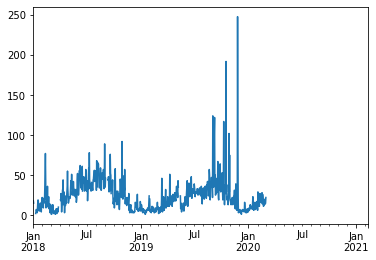

In [65]:
model_data['X_pm10'].plot()

## X_ws, X_wd, X_rh, X_temp
- present-day variables from SolarGIS

In [66]:
# read data 
geodat_data = pd.read_csv(r'C:\Users\sandra.villamar\OneDrive - EDF Renewable Energy\Projects\DHI Analysis\GeoDat_Report_2_17_2021.csv', 
                          skiprows=47,
                          usecols=['Date Time (Local)', 'WS', 'WD', 'RH', 'TEMP'])
geodat_data = geodat_data.set_index(['Date Time (Local)'])
geodat_data.columns = ['X_temp', 'X_rh', 'X_ws', 'X_wd']

In [67]:
# placeholder for new index
new_ind = pd.Series(geodat_data.index)

for i in range(len(new_ind)):
    # convert to timezone w/o DLS
    new_ind[i] = pd.to_datetime(new_ind[i]).tz_convert(location['timezone'])

#set new index
geodat_data.set_index(new_ind, inplace=True)

In [68]:
# average hourly to daily
geodat_data = geodat_data.resample('D').mean()

In [69]:
# add to model_data
model_data_og = pd.merge(geodat_data, model_data, how='outer', left_index=True, right_index=True)
model_data = model_data_og.dropna()

## Export model_data

In [71]:
model_data

,X_temp,X_rh,X_ws,X_wd,X_pm10,y_sratio_change
2018-03-08 00:00:00-08:00,12.537500,27.895833,3.158333,291.333333,13.0,-0.003419
2018-03-09 00:00:00-08:00,13.720833,42.962500,3.316667,280.458333,9.0,-0.000144
2018-03-18 00:00:00-08:00,6.700000,58.975000,1.962500,207.125000,3.0,0.001519
2018-03-19 00:00:00-08:00,9.966667,39.808333,2.104167,177.833333,5.0,-0.001188
2018-03-25 00:00:00-08:00,5.700000,66.700000,4.950000,283.833333,6.0,0.000612
...,...,...,...,...,...,...
2020-02-25 00:00:00-08:00,12.329167,32.450000,2.820833,148.500000,16.0,-0.000608
2020-02-26 00:00:00-08:00,12.083333,14.541667,2.558333,70.583333,20.0,-0.000373
2020-02-27 00:00:00-08:00,13.450000,16.154167,2.333333,147.000000,14.0,0.000136
2020-02-28 00:00:00-08:00,15.312500,14.445833,1.970833,96.541667,15.0,0.002048


In [72]:
model_data.to_pickle('./model_data.pkl')

# Data for ANN-8
- X (matrix of observations): cols = PM10, WS, WD, RH, Temp + (prev day) PM10, WS, RH
- y (vector): daily change in SR

In [73]:
# check if all dates exist in index so prev day calc is correct
pd.date_range(start = model_data_og.index.min(), end = model_data_og.index.max()).difference(model_data_og.index)

DatetimeIndex([], dtype='datetime64[ns, Etc/GMT+8]', freq=None)

In [80]:
# copy data from ANN-5
model_data_8 = model_data_og.copy()

# add cols of pm10, ws, rh from previous day
model_data_8['X_pm10_prev'] = np.append(np.nan, model_data_8['X_pm10'].values[:-1])
model_data_8['X_ws_prev'] = np.append(np.nan, model_data_8['X_ws'].values[:-1])
model_data_8['X_rh_prev'] = np.append(np.nan, model_data_8['X_rh'].values[:-1])

model_data_8.dropna(inplace=True)
model_data_8

,X_temp,X_rh,X_ws,X_wd,X_pm10,y_sratio_change,X_pm10_prev,X_ws_prev,X_rh_prev
2018-03-08 00:00:00-08:00,12.537500,27.895833,3.158333,291.333333,13.0,-0.003419,9.0,1.712500,11.100000
2018-03-09 00:00:00-08:00,13.720833,42.962500,3.316667,280.458333,9.0,-0.000144,13.0,3.158333,27.895833
2018-03-18 00:00:00-08:00,6.700000,58.975000,1.962500,207.125000,3.0,0.001519,1.0,3.479167,71.158333
2018-03-19 00:00:00-08:00,9.966667,39.808333,2.104167,177.833333,5.0,-0.001188,3.0,1.962500,58.975000
2018-03-25 00:00:00-08:00,5.700000,66.700000,4.950000,283.833333,6.0,0.000612,8.0,4.183333,67.991667
...,...,...,...,...,...,...,...,...,...
2020-02-25 00:00:00-08:00,12.329167,32.450000,2.820833,148.500000,16.0,-0.000608,13.0,2.750000,61.229167
2020-02-26 00:00:00-08:00,12.083333,14.541667,2.558333,70.583333,20.0,-0.000373,16.0,2.820833,32.450000
2020-02-27 00:00:00-08:00,13.450000,16.154167,2.333333,147.000000,14.0,0.000136,20.0,2.558333,14.541667
2020-02-28 00:00:00-08:00,15.312500,14.445833,1.970833,96.541667,15.0,0.002048,14.0,2.333333,16.154167


In [78]:
# export data
model_data_8.to_pickle('./model_data_8.pkl')